# Vignette 3: Evaluating methods under two scenarios: offtarget recovery and pathway activity

Welcome to our third vignette! Here we assume you already know the basics of `Networkcommons`. If you don't, please check our [first vignette](1_quickstart.html), where we contextualise a simple network, and our [second vignette](2_multiple_methods.html), where we apply different methods to a problem and visualise the different solution networks.

In this vignette, we will start exploring how we can evaluate the different methods used for network contextualisation. As already hinted at the end of the second vignette, it is not trivial how to decide which method performs better. In `Networkcommons`, we have included four strategies to do so, whose details can be found in this [section](../benchmarks.html). 

Here, we will showcase two of them: [offtarget recovery](../benchmarks.html#offtarget-recovery) and [pathway enrichment analysis](../benchmarks.html#pathway-enrichment-analysis). In the first one, we aim to recover as many drug offtargets as possible, while in the latter setting, the components of a perturbed pathway should be overrepresented in the solution networks.

In [1]:
import networkcommons as nc
import pandas as pd
import decoupler as dc

## 1. Loading preprocessed transcriptomics data

Like in the previous vignettes, we will use a specific contrast from the [PANACEA](../datasets.html#panacea) (Afatinib versus DMSO in ASPC cell line) to extract the transcription factors that are dysregulated in this scenario. We will skip the explanation of the data processing, but it can be found in the [PANACEA data section](../datasets.html#panacea). Here, we will use H1793 cells treated with neratinib (an EGFR inhibitor) vs DMSO as control.

In [2]:
# downstream layer
dc_estimates = nc.data.omics.panacea_tables(cell_line='H1793', drug='NERATINIB', type='TF_scores')
dc_estimates.set_index('items', inplace=True)
measurements = nc.utils.targetlayer_formatter(dc_estimates, act_col='act')

# upstream layer
source_df = pd.DataFrame({'source': ['EGFR'], 
                          'sign': [-1]}, columns=['source', 'sign'])
source_df.set_index('source', inplace=True)
sources = source_df['sign'].to_dict()

## 2. Network inference

Now we have our sources and targets, we will import the PKN from OmniPath:

In [3]:
network = nc.data.network.get_omnipath()
graph = nc.utils.network_from_df(network)

Now, we will contextualise different subnetworks using different methods.

In [ ]:
# topological methods
shortest_path_network, shortest_paths_list = nc.methods.run_shortest_paths(graph, sources, measurements)
shortest_sc_network, shortest_sc_list = nc.methods.run_sign_consistency(shortest_path_network, shortest_paths_list, sources, measurements)
all_paths_network, all_paths_list = nc.methods.run_all_paths(graph, sources, measurements, depth_cutoff=3)
allpaths_sc_network, allpaths_sc_list = nc.methods.run_sign_consistency(all_paths_network, all_paths_list, sources, measurements)


# diffusion-like methods
ppr_network = nc.methods.add_pagerank_scores(graph, sources, measurements, personalize_for='source')
ppr_network = nc.methods.add_pagerank_scores(ppr_network, sources, measurements, personalize_for='target')
ppr_network = nc.methods.compute_ppr_overlap(ppr_network, percentage=1)
shortest_ppr_network, shortest_ppr_list = nc.methods.run_shortest_paths(ppr_network, sources, measurements)
shortest_sc_ppr_network, shortest_sc_ppr_list = nc.methods.run_sign_consistency(shortest_ppr_network, shortest_ppr_list, sources, measurements)

# ILP-based
corneto_network = nc.methods.run_corneto_carnival(graph, sources, measurements, betaWeight=0.01, solver='GUROBI')

We will now store the networks in a dictionary to ease handling. 

In [5]:
# we include all the networks in a dictionary with custom labels
networks = {
    'shortest_path': shortest_path_network,
    'shortest_path_sc': shortest_sc_network,
    'all_paths': all_paths_network,
    'all_paths_sc': allpaths_sc_network,
    'shortest_ppr_network': shortest_ppr_network,
    'shortest_ppr_sc_network': shortest_sc_ppr_network,
    'corneto': corneto_network
}

## 3. Evaluation strategy using offtarget recovery

Now, we are ready to start our assessment of the methods' performance! A first evaluation strategy we can use is based on the recovery of offtarget(s) in the solution networks. Here, we assume that the measurements we use as downstream values are a product not only of the perturbation of the primary drug target, but also of the perturbation of one or more offtarget nodes. Therefore, a network that can accurately contextualise these effects, will have a higher share of offtargets among the subnetwork nodes. You can find more details about this setting in the [Evaluation strategies details page](../benchmarks.html#offtarget-recovery).

In this specific case, we want to evaluate whether the networks contain the offtarget MAPKAPK2, as contained in the PANACEA gold standard.

In [6]:
panacea_gold_standard = nc.data.omics.panacea_gold_standard()
neratinib_offtargets = panacea_gold_standard[(panacea_gold_standard['cmpd'] == 'NERATINIB') & (~panacea_gold_standard['target'].isin(sources.keys()))].target.tolist()
offtarget_res = nc.eval.get_metric_from_networks(networks, nc.eval.get_recovered_offtargets, offtargets=neratinib_offtargets)
offtarget_res

,n_offtargets,perc_offtargets,network,type,method
0,0,0.0,shortest_path,real,shortest_path
1,0,0.0,shortest_path_sc,real,shortest_path_sc
2,0,0.0,all_paths,real,all_paths
3,0,0.0,all_paths_sc,real,all_paths_sc
4,0,0.0,shortest_ppr_network,real,shortest_ppr_network
5,0,0.0,shortest_ppr_sc_network,real,shortest_ppr_sc_network
6,0,0.0,corneto,real,corneto


Unfortunately, none of them managed to recover this effect. This might be due to several reasons, but the main limitation is that only offtargets that are reachable from the source node can be considered. Everything not reachable from the source cannot be part of a solution network. In addition, having only one offtarget greatly reduces the statistical power to draw conclusions here (is this one offtarget missing just per chance, or is there a mechanistic explanation behind?). While this approach can be useful in some situations, it is equally important to assess whether the results might be biased or not in every case.

However, this was just an example using one drug and one cell line combination. However, in order to get a more unbiased metric, we can repeat the same analysis using the whole PANACEA dataset. Here, we provide a one_liner that performs systematic network inference using the methods implemented in NetworkCommons, using the different cell line and drug combinations available in the PANACEA dataset. Here, due to computational power constrains, we will do this on one cell line, H1793, and all available drugs. 

In [7]:
offtarget_results = nc.eval.get_offtarget_panacea_evaluation(cell='H1793')

(CORNETO) Sep 12 02:55:41 PM - INFO    : 1/1 inputs mapped to the graph
(CORNETO) Sep 12 02:55:41 PM - INFO    : 23/25 outputs mapped to the graph
(CORNETO) Sep 12 02:55:41 PM - INFO    : Pruning the graph with size: V x E = (4946, 13172)...
(CORNETO) Sep 12 02:55:41 PM - INFO    : Finished. Final size: V x E = (1197, 5840).
(CORNETO) Sep 12 02:55:41 PM - INFO    : 1/1 inputs after pruning.
(CORNETO) Sep 12 02:55:41 PM - INFO    : 22/23 outputs after pruning.
(CORNETO) Sep 12 02:55:41 PM - INFO    : Converting into a flow graph...
(CORNETO) Sep 12 02:55:42 PM - INFO    : Creating a network flow problem...
(CORNETO) Sep 12 02:55:42 PM - INFO    : Preprocess completed.
(CVXPY) Sep 12 02:55:42 PM: Your problem has 27092 variables, 65950 constraints, and 0 parameters.
(CVXPY) Sep 12 02:55:42 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 12 02:55:42 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Se

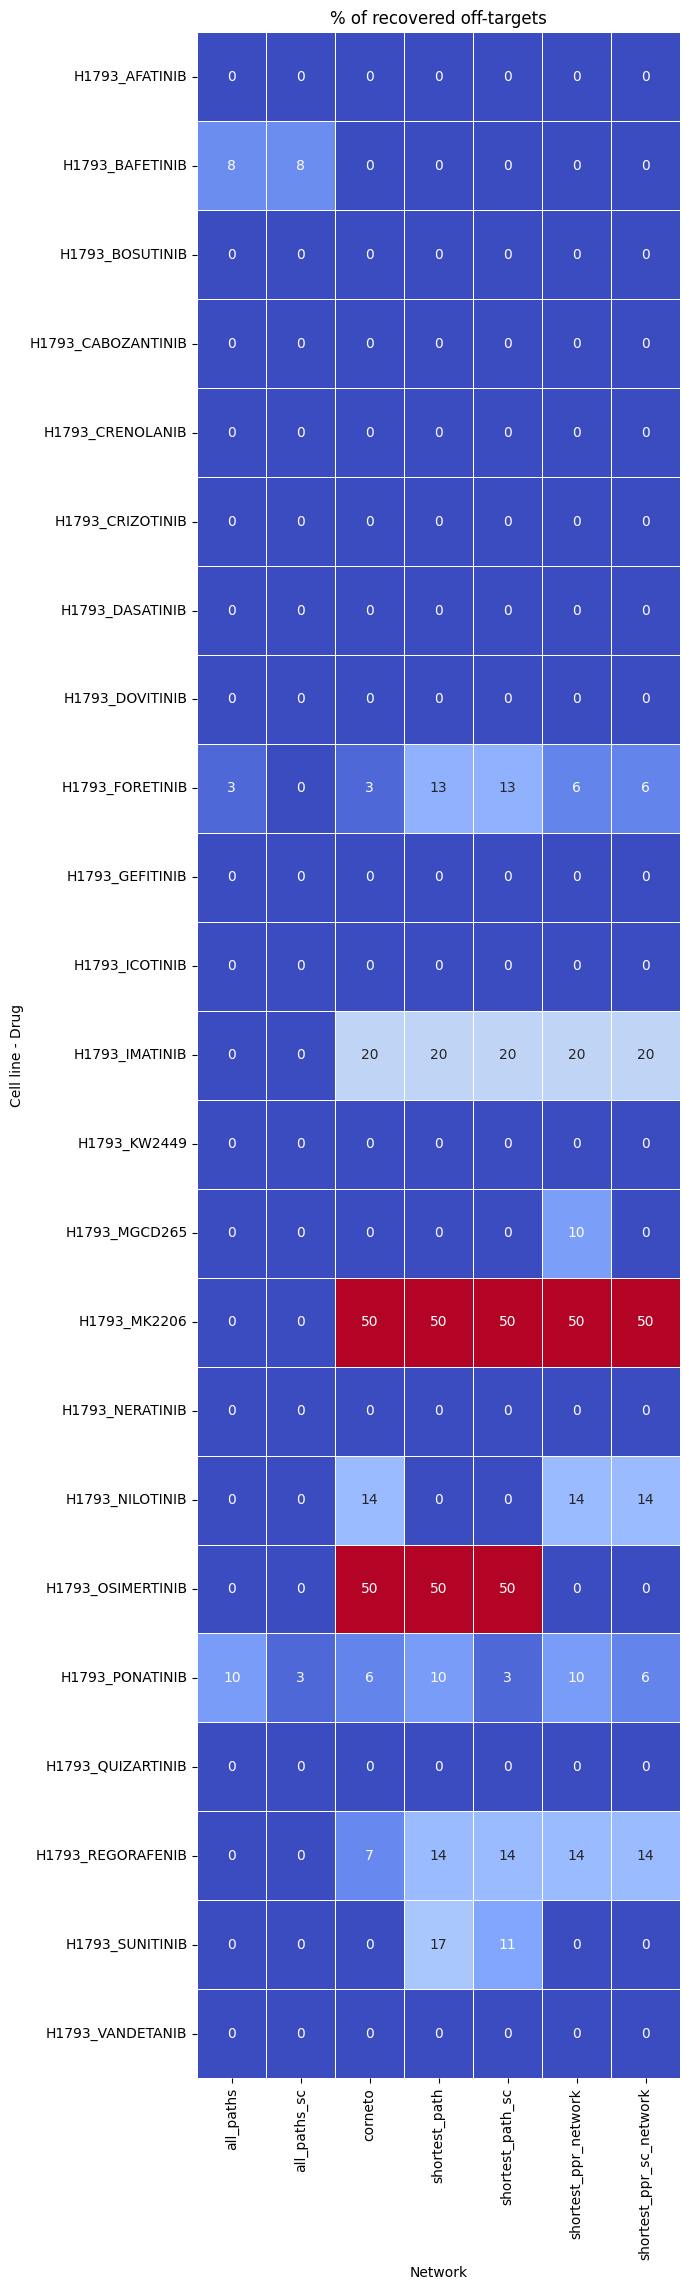

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [11]:
nc.visual.create_heatmap(offtarget_results,
    value_col='perc_offtargets',
    y_axis_col='cell_drug',
    x_axis_col='method',
    cmap='coolwarm',
    title='% of recovered off-targets',
    y_label='Cell line - Drug',
    render=True
    )

## 4. Evaluation strategy using pathway enrichment analysis

For the second evaluation setting, we will follow here a very intuitive approach: if a network contextualises properly a given perturbation, a large share of members of the perturbed pathway will appear in the solution network. Therefore, we will perform Overrepresentation analysis between the members of these networks, and a gene set from [Biocarta](https://www.gsea-msigdb.org/gsea/msigdb/cards/BIOCARTA_EGF_PATHWAY) containing the members of the EGF canonical pathway, in addition to an alternative pathway involving SMRT inhibition by the Tyrosine-Kinase signalling pathway. If the network contextualises properly, the affected pathway(s) will have a higher ORA score (they will be ranked higher than other pathways). You can find more details about this strategy in the [Evaluation strategies details page](../benchmarks.html#pathway-enrichment-analysis).

First, we neet the pathway signatures from BioCarta, which are available in the MSigDB database.

In [ ]:
signatures = dc.get_resource('MSigDB', organism='human')
biocarta_elements = signatures[signatures['collection'] == 'biocarta_pathways']
biocarta_elements.rename(columns={'geneset': 'source', 'genesymbol': 'target'}, inplace=True)
biocarta_elements.drop_duplicates(inplace=True)

In [13]:
ora_results = nc.eval.get_metric_from_networks(networks, nc.eval.run_ora, net=biocarta_elements)

In [15]:
biocarta_elements

,target,collection,source
260,ICOSLG,biocarta_pathways,BIOCARTA_CTLA4_PATHWAY
387,FOSL2,biocarta_pathways,BIOCARTA_RANKL_PATHWAY
938,PLAU,biocarta_pathways,BIOCARTA_FIBRINOLYSIS_PATHWAY
1091,PLAU,biocarta_pathways,BIOCARTA_PLATELETAPP_PATHWAY
1684,BTG1,biocarta_pathways,BIOCARTA_BTG2_PATHWAY
...,...,...,...
2392873,IFNA13,biocarta_pathways,BIOCARTA_INFLAM_PATHWAY
2397261,GSTA2,biocarta_pathways,BIOCARTA_ARENRF2_PATHWAY
2401665,SAG,biocarta_pathways,BIOCARTA_RHODOPSIN_PATHWAY
2402175,GRK1,biocarta_pathways,BIOCARTA_RHODOPSIN_PATHWAY


In [28]:
# we manually input the expected perturbed pathways
elements = ['BIOCARTA_EGF_PATHWAY', 'BIOCARTA_EGFR_SMRTE_PATHWAY']

# and we take 10 random pathways to complete the list (some of them might be missing in the vis since an ora score might have not been computed for them)
elements = elements + biocarta_elements[~biocarta_elements['source'].isin(elements)].source.sample(n=10).tolist()

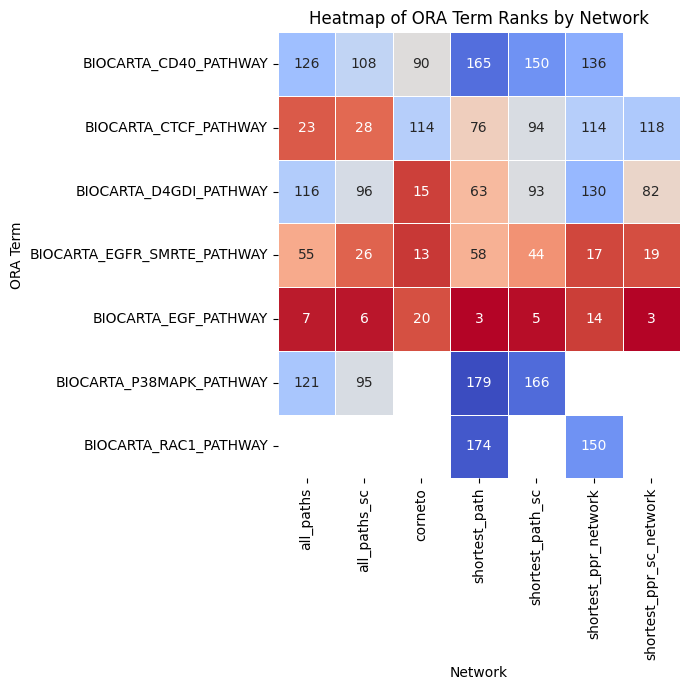

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [29]:
nc.visual.create_heatmap(ora_results, elements, render=True)

Almost all methods correctly identified the perturbed pathway. Shortest paths performed best, while ILP-based corneto performed worst under this assumption.

And that was it for now! We hope you found this tutorial helpful. We focused here on strategies to evaluate the networks, showcasing two of them.
However, this is just the beginning! We aim to expand this collection of tools and methods by incorporating more data sources, methods, evaluation strategies and visualizations.

If you have any questions or feedback, or you would like to contribute, please reach out!. In addition, check our Contribution guidelines for [Data](../guidelines/guide_1_data.html), [Methods](../guidelines/guide_2_methods.html) and [Evaluation strategies](../guidelines/guide_3_eval.html).